
# 1. Import Libraries

In [1]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pickle
import random
from tqdm import tqdm


# 2. Mount Google Drive

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#3. Dataset Preparation

In [3]:
# Set the dataset directory path
dataset_dir = '/content/drive/My Drive/chest_xray'



## Verify Dataset Structure

In [4]:
# Verify the dataset structure
import os

def verify_dataset_structure(dataset_dir):
    required_dirs = ['train', 'val', 'test']
    for dir_name in required_dirs:
        dir_path = os.path.join(dataset_dir, dir_name)
        if not os.path.exists(dir_path):
            print(f"Directory {dir_path} does not exist.")
            return False
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_dir = os.path.join(dir_path, class_name)
            if not os.path.exists(class_dir):
                print(f"Directory {class_dir} does not exist.")
                return False
    print("Dataset structure is correct.")
    return True

verify_dataset_structure(dataset_dir)


Dataset structure is correct.


True

#4.DnCNN Model Implementation

In [5]:
# DnCNN Model definition
class DnCNN(nn.Module):
    def __init__(self, channels=1, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers_ = []

        # First layer
        layers_.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers_.append(nn.ReLU(inplace=True))

        # Hidden layers
        for _ in range(num_of_layers - 2):
            layers_.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers_.append(nn.BatchNorm2d(features))
            layers_.append(nn.ReLU(inplace=True))

        # Last layer
        layers_.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))

        self.dncnn = nn.Sequential(*layers_)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out  # Residual learning


#5.Data Loading and Preprocessing

In [6]:
class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, image_size=(256, 256), transform=None, add_noise=False):
        self.normal_dir = os.path.join(data_dir, 'NORMAL')
        self.pneumonia_dir = os.path.join(data_dir, 'PNEUMONIA')
        self.image_paths = []
        self.labels = []
        self.image_size = image_size
        self.transform = transform
        self.add_noise = add_noise  # Flag to add noise

        # Load NORMAL images
        for img_name in os.listdir(self.normal_dir):
            self.image_paths.append(os.path.join(self.normal_dir, img_name))
            self.labels.append('NORMAL')

        # Load PNEUMONIA images
        for img_name in os.listdir(self.pneumonia_dir):
            self.image_paths.append(os.path.join(self.pneumonia_dir, img_name))
            self.labels.append('PNEUMONIA')

    def __len__(self):
        return len(self.image_paths)

    def add_gaussian_noise(self, image, mean=0, std=25):
        gauss = np.random.normal(mean, std, image.shape).astype('float32')
        noisy = image + gauss
        noisy = np.clip(noisy, 0, 255)
        return noisy

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, self.image_size)
        original_image = image.astype('float32')

        # Optionally add noise
        if self.add_noise:
            noisy_image = self.add_gaussian_noise(original_image)
        else:
            noisy_image = original_image  # No noise added

        # Normalize
        original_image = original_image / 255.0
        noisy_image = noisy_image / 255.0

        # Convert to tensors
        noisy_image_tensor = torch.from_numpy(noisy_image).unsqueeze(0)
        original_image_tensor = torch.from_numpy(original_image).unsqueeze(0)

        return noisy_image_tensor, original_image_tensor, label


#6. Training Functions

## 6.1 Train DnCNN Model

In [7]:
def train_dncnn_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for noisy_images, clean_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)

            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, clean_images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for noisy_images, clean_images, _ in val_loader:
                noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
                outputs = model(noisy_images)
                loss = criterion(outputs, clean_images)
                val_loss += loss.item()
        model.train()

        print(f"Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")
    print("DnCNN Training completed.")


##6.2 Denoise Images

In [8]:
def denoise_images(model, dataloader, device):
    denoised_images = []
    labels = []
    model.eval()
    with torch.no_grad():
        for noisy_images, _, label in tqdm(dataloader, desc="Denoising Images"):
            noisy_images = noisy_images.to(device)
            outputs = model(noisy_images)
            outputs = outputs.cpu().numpy()
            for i in range(outputs.shape[0]):
                denoised_image = outputs[i].squeeze() * 255.0
                denoised_image = np.clip(denoised_image, 0, 255).astype(np.uint8)
                denoised_images.append(denoised_image)
                labels.append(label[i])
    return denoised_images, labels


#7. Classification Model Implementation

##Prepare Data for Classification

In [41]:
def prepare_classification_data(denoised_images, labels, image_size=(256, 256)):
    images = np.array(denoised_images)
    images = images.reshape(-1, image_size[0], image_size[1], 1)
    images = images / 255.0  # Normalize

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_one_hot = to_categorical(labels_encoded, num_classes=2)

    # Save the label encoder
    with open('label_encoder_classification.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)

    return images, labels_one_hot


##Classification Model Definition

In [42]:
def create_classification_model(input_shape=(256, 256, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # Output layer for 2 classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


##Train Classification Model

In [46]:
def train_classification_model(model, X_train, y_train, X_val, y_val):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'classification_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=[early_stopping, model_checkpoint]
    )
    return history


#8. Main Execution

##Set Hyperparameters and Paths

In [12]:
# Paths
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Hyperparameters
num_epochs_dncnn = 5
batch_size = 8
learning_rate = 0.001
image_size = (256, 256)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


#9. Create Datasets and Dataloaders

In [13]:
# Create datasets
train_dataset = ChestXrayDataset(train_dir, image_size=image_size, add_noise=True)
val_dataset = ChestXrayDataset(val_dir, image_size=image_size, add_noise=True)
test_dataset = ChestXrayDataset(test_dir, image_size=image_size, add_noise=False)  # No noise added to test data

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


##Initialize DnCNN Model

In [14]:
# Initialize DnCNN model, criterion, and optimizer
dncnn_model = DnCNN(channels=1, num_of_layers=17).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dncnn_model.parameters(), lr=learning_rate)


##Train DnCNN Model


In [16]:
# Train DnCNN model
train_dncnn_model(dncnn_model, train_loader, val_loader, num_epochs_dncnn, criterion, optimizer, device)




Epoch 1/5: 100%|██████████| 399/399 [03:54<00:00,  1.70it/s]


Training Loss: 0.0008, Validation Loss: 0.0007


Epoch 2/5: 100%|██████████| 399/399 [03:58<00:00,  1.68it/s]


Training Loss: 0.0008, Validation Loss: 0.0012


Epoch 3/5: 100%|██████████| 399/399 [03:58<00:00,  1.67it/s]


Training Loss: 0.0008, Validation Loss: 0.0007


Epoch 4/5: 100%|██████████| 399/399 [03:58<00:00,  1.67it/s]


Training Loss: 0.0008, Validation Loss: 0.0006


Epoch 5/5: 100%|██████████| 399/399 [03:58<00:00,  1.67it/s]


Training Loss: 0.0007, Validation Loss: 0.0006
DnCNN Training completed.


In [17]:
# Save DnCNN model
torch.save(dncnn_model.state_dict(), 'dncnn_trained.pth')
print("DnCNN model saved.")

DnCNN model saved.


#10. Denoising Images

In [18]:
# Denoise images using DnCNN
# Denoise train images
train_denoised_images, train_labels = denoise_images(dncnn_model, train_loader, device)
# Denoise validation images
val_denoised_images, val_labels = denoise_images(dncnn_model, val_loader, device)
# Denoise test images
test_denoised_images, test_labels = denoise_images(dncnn_model, test_loader, device)


Denoising Images: 100%|██████████| 78/78 [02:42<00:00,  2.08s/it]


array([[ 0,  5,  7, ..., 14, 13,  0],
       [ 2,  6,  0, ..., 18, 24, 19],
       [ 8,  4,  1, ..., 28, 23, 24],
       ...,
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 5,  3,  0, ...,  1,  1,  7],
       [ 0,  0, 28, ...,  0, 29, 10]], dtype=uint8)
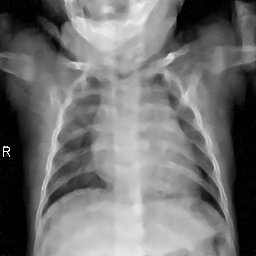

In [36]:
train_denoised_images[0]

In [40]:
import os
import numpy as np
from PIL import Image

# Function to save denoised images in folders based on labels
def save_denoised_images(denoised_images, labels, output_folder):
    # Get unique labels
    unique_labels = np.unique(labels)

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Create a folder for each unique label
    for label in unique_labels:
        label_folder = os.path.join(output_folder, f"label_{label}")
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)

    # Save each denoised image in its respective label folder
    for i, (image, label) in enumerate(zip(denoised_images, labels)):
        label_folder = os.path.join(output_folder, f"label_{label}")
        image_path = os.path.join(label_folder, f"image_{i}.png")

        # Convert numpy array to an image and save it
        image = (image * 255).astype(np.uint8)  # Rescale to 0-255 if needed
        im = Image.fromarray(image)
        im.save(image_path)

# Example usage:
# Save denoised train images
save_denoised_images(train_denoised_images, train_labels, '/content/drive/MyDrive/train_denoised')

# Save denoised validation images
save_denoised_images(val_denoised_images, val_labels, '/content/drive/MyDrive/val_denoised')

# Save denoised test images
save_denoised_images(test_denoised_images, test_labels, '/content/drive/MyDrive/test_denoised')


In [39]:

from google.colab import files
files.download('/content/test_denoised')
files.download('/content/val_denoised')
files.download('/content/train_denoised')

print("Download complete.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download complete.


#11. Prepare Data for Classification

In [19]:
# Prepare data for classification
X_train, y_train = prepare_classification_data(train_denoised_images, train_labels, image_size=image_size)
X_val, y_val = prepare_classification_data(val_denoised_images, val_labels, image_size=image_size)
X_test, y_test = prepare_classification_data(test_denoised_images, test_labels, image_size=image_size)


#12. Classification Model Training

In [47]:
# Define input shape for the classification model
input_shape = (256, 256, 1)

# Create classification model
classification_model = create_classification_model(input_shape=input_shape)

# Now train the classification model with the updated callback
history = train_classification_model(classification_model, X_train, y_train, X_val, y_val)

# Save the final classification model in .keras format
classification_model.save('classification_model.keras')  # Updated final model save to .keras
print("Classification model saved.")


Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6264 - loss: 0.8728
Epoch 1: val_loss improved from inf to 0.33306, saving model to classification_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.6276 - loss: 0.8697 - val_accuracy: 0.9375 - val_loss: 0.3331
Epoch 2/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9114 - loss: 0.2378
Epoch 2: val_loss improved from 0.33306 to 0.25002, saving model to classification_best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.9117 - loss: 0.2370 - val_accuracy: 0.9375 - val_loss: 0.2500
Epoch 3/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9601 - loss: 0.1320
Epoch 3: val_loss did not improve from 0.25002
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9600 - loss: 0.1319 - val_accuracy: 0.8125 - val_loss: 0.3449
Epoch 4/20
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9590 - loss: 0.1141
Epoch 4: val_loss did not improve from 0.25002
100

#13. Evaluate Model

In [48]:
# Evaluate on test set
test_loss, test_acc = classification_model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")


20/20 - 2s - 102ms/step - accuracy: 0.7644 - loss: 2.1203
Test accuracy: 0.7644


#Test the Classification Model on New Images

##Load Models

In [49]:
# Load the classification model
classification_model = tf.keras.models.load_model('/content/classification_best_model.keras')

# Load the label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Load the DnCNN model
dncnn_model = DnCNN(channels=1, num_of_layers=17).to(device)
dncnn_model.load_state_dict(torch.load('dncnn_trained.pth', map_location=device))
dncnn_model.eval()
print("Models loaded.")


Models loaded.


<ipython-input-49-af133ec8bf29>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dncnn_model.load_state_dict(torch.load('dncnn_trained.pth', map_location=device))


##Predict Function

In [50]:
# Function to preprocess and denoise a new image
def preprocess_and_denoise_image(image_path, dncnn_model, device):
    # Load and preprocess image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, image_size)
    original_image = image.astype('float32')
    noisy_image = train_dataset.add_gaussian_noise(original_image)
    noisy_image = noisy_image / 255.0
    noisy_image_tensor = torch.from_numpy(noisy_image).unsqueeze(0).unsqueeze(0).to(device)

    # Denoise image
    dncnn_model.eval()
    with torch.no_grad():
        denoised_tensor = dncnn_model(noisy_image_tensor)
    denoised_image = denoised_tensor.squeeze().cpu().numpy() * 255.0
    denoised_image = np.clip(denoised_image, 0, 255).astype(np.uint8)

    # Prepare image for classification model
    denoised_image = denoised_image / 255.0
    denoised_image = denoised_image.reshape(1, image_size[0], image_size[1], 1)

    return denoised_image

# Predict function
def predict_image_class(image_path):
    denoised_image = preprocess_and_denoise_image(image_path, dncnn_model, device)
    predictions = classification_model.predict(denoised_image)
    predicted_class_index = np.argmax(predictions, axis=1)
    predicted_label = label_encoder.inverse_transform(predicted_class_index)
    return predicted_label[0]


##Example Usage

In [52]:
# Example usage
# Replace 'path_to_new_chest_xray_image.png' with the path to your test image
image_path = '/content/train_denoised/label_PNEUMONIA/image_1002.png'  # Example path
predicted_label = predict_image_class(image_path)
print(f"The predicted class is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The predicted class is: PNEUMONIA
